In [55]:
# Prerequisites
# ! pip install -U pandas
# ! pip install -U nltk  
# ! pip install -U gensim     
# ! pip install -U wordcloud
# ! python3 -m spacy download en_core_web_sm
# ! pip install -U pyLDAvis

In [56]:
# Importing Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [57]:
# Loading Dataset
df=pd.read_csv('RAW_NEWS.csv')


# Temporarily using first 100 news only
# df = df[:100]
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...


# PRE-PROCESSING DATA

In [58]:
# Cleansing the News heading by removing un-nessary words
df['HeadingOfNews'] = df['HeadingOfNews'].str.replace('\+|- DAWN.COM| Newspaper', '')

# Removing "Published in Dawn" from the end off news content
df['BodyOfNews'] = df['BodyOfNews'].str.split('Published in Dawn,').str[0]

# Comibining News Heading and Body
df['originalCombined'] = df['HeadingOfNews'] + ' ' + df['BodyOfNews']
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...


In [59]:
# download stopwords
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aniqurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['originalCombined']))

In [61]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [62]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    # nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [63]:
def preprocess(text):
    # Remove Stop Words
    data_words_nostops = remove_stopwords(text)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_lemmatized)
    # Form Trigrams
    data_words_trigrams = make_trigrams(data_words_bigrams)
    return data_lemmatized

In [64]:
data_lemmatized = preprocess(data_words)
df['clean'] = data_lemmatized

df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[rue, decision, grant, extension, bajwa, week,..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[opted, suicide, attack, treat, book, case, po..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[police, official, martyr, nowshera, gun, poli..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal, miner, kill, gas, explosion, least, coa..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throw, joint, petition, perk, teacher, re..."


# VISUALIZE CLEANED UP DATASET

In [65]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

print("Word Count Total:", len(list_of_words))
# Obtain the total number of unique words
print("Word Count Unique:", len(list(set(list_of_words))))

Word Count Total: 481605
Word Count Unique: 17944


<AxesSubplot: xlabel='count', ylabel='Topic'>

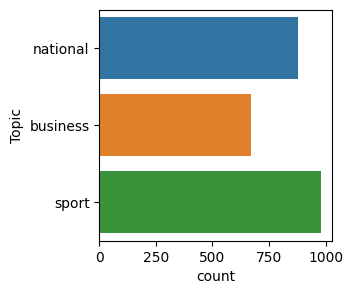

In [66]:
# plot the number of samples in 'HeadingOfNews'
plt.figure(figsize = (3, 3))
sns.countplot(y = "Topic", data = df)

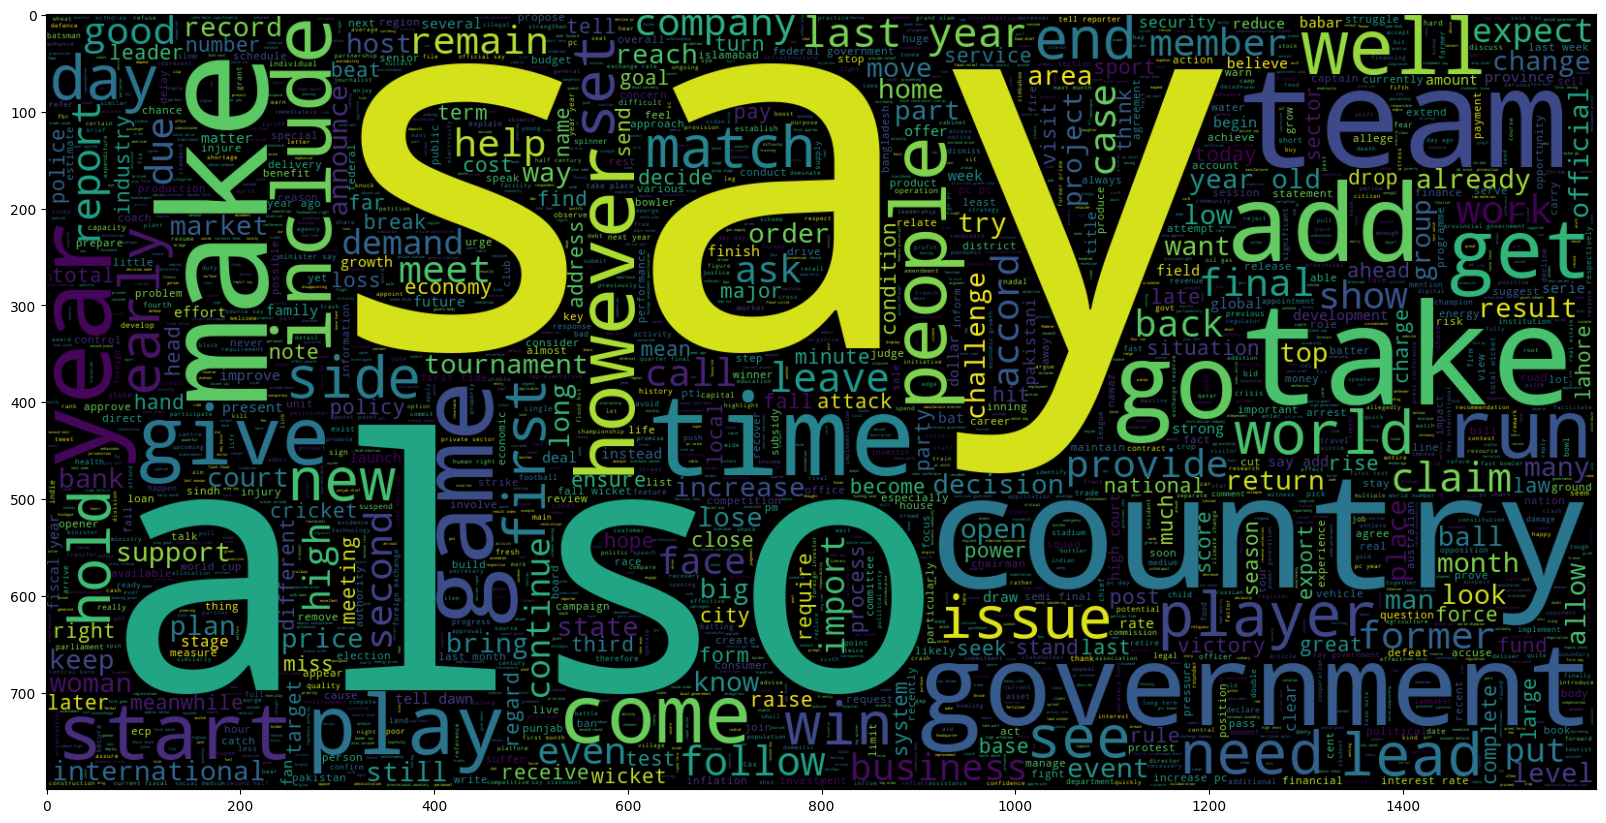

In [67]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df.clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [68]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 643


# FEATURE EMBEDDING USING BAG OF WORDS

In [71]:
id2word = corpora.Dictionary(data_lemmatized)

corpus = []
for text in data_lemmatized:
    new = id2word.doc2bow(text)
    corpus.append(new)

print ("BOW News1:\n",corpus[0])
# firstword = id2word[[0][:1][0]]
# print (firstword)


BOW News1:
 [(0, 4), (1, 1), (2, 1), (3, 3), (4, 2), (5, 2), (6, 2), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 7), (15, 1), (16, 2), (17, 1), (18, 5), (19, 2), (20, 1), (21, 5), (22, 1), (23, 6), (24, 2), (25, 2), (26, 5), (27, 3), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 4), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 6), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 2), (76, 3), (77, 1), (78, 1), (79, 1), (80, 2), (81, 2)]


# LDA TOPIC MODELLING

In [72]:
TOPIC_COUNT = 3

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=TOPIC_COUNT,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [73]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.022264  0.187785       1        1  36.301695
0      0.207323 -0.093698       2        1  33.495929
1     -0.185059 -0.094086       3        1  30.202376, topic_info=            Term         Freq        Total Category  logprob  loglift
607           pc  2583.000000  2583.000000  Default  30.0000  30.0000
797        price  1295.000000  1295.000000  Default  29.0000  29.0000
1332       match  1307.000000  1307.000000  Default  28.0000  28.0000
580     increase  1364.000000  1364.000000  Default  27.0000  27.0000
26    government  3297.000000  3297.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
38         month   765.949633  1411.991547   Topic3  -5.2465   0.5856
399      include   689.211461  1564.225060   Topic3  -5.3521   0.3777
152         also   768.338112  2948.537974   Topic3  -5.2434  -0.1476
613        power   549.245405   878.737900   Topic3  -5.5791   0.7273
116         last   539.815134  1934.773996   Topic3  -5.5964  -0.0793

[214 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.539166     add
0         2  0.250026     add
0         3  0.210911     add
151       1  0.998990  allege
152       1  0.523310    also
...     ...       ...     ...
149       2  0.825249   world
149       3  0.101966   world
81        1  0.094217    year
81        2  0.456748    year
81        3  0.449067    year

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])